In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
from PIL import Image
import pickle
import json

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Define class names
CLASS_NAMES = [
    'Left Bundle Branch Block',
    'Normal',
    'Premature Atrial Contraction',
    'Premature Ventricular Contractions',
    'Right Bundle Branch Block',
    'Ventricular Fibrillation'
]

In [4]:
# Configuration
CONFIG = {
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'LEARNING_RATE': 0.001,
    'VALIDATION_SPLIT': 0.2,
    'NUM_CLASSES': len(CLASS_NAMES)
}

In [5]:
class ECGArrhythmiaClassifier:
    def __init__(self, config):
        self.config = config
        self.model = None
        self.history = None
        self.label_encoder = LabelEncoder()

    def load_and_preprocess_data(self, train_dir, test_dir):
        """Load and preprocess ECG spectral images"""
        print("Loading and preprocessing data...")

        # Data generators with augmentation for training
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            validation_split=self.config['VALIDATION_SPLIT']
        )

        # Data generator for test (no augmentation)
        test_datagen = ImageDataGenerator(rescale=1./255)

        # Load training data
        self.train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=self.config['IMG_SIZE'],
            batch_size=self.config['BATCH_SIZE'],
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        # Load validation data
        self.validation_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=self.config['IMG_SIZE'],
            batch_size=self.config['BATCH_SIZE'],
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        # Load test data
        self.test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=self.config['IMG_SIZE'],
            batch_size=self.config['BATCH_SIZE'],
            class_mode='categorical',
            shuffle=False
        )

        print(f"Training samples: {self.train_generator.samples}")
        print(f"Validation samples: {self.validation_generator.samples}")
        print(f"Test samples: {self.test_generator.samples}")
        print(f"Classes: {list(self.train_generator.class_indices.keys())}")

        return self.train_generator, self.validation_generator, self.test_generator

    def build_model(self):
        """Build CNN model architecture"""
        print("Building model architecture...")

        model = models.Sequential([
            # First Convolutional Block
            layers.Conv2D(32, (3, 3), activation='relu',
                         input_shape=(*self.config['IMG_SIZE'], 3)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Second Convolutional Block
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Third Convolutional Block
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Fourth Convolutional Block
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Fifth Convolutional Block
            layers.Conv2D(512, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),

            # Dense Layers
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            # Output Layer
            layers.Dense(self.config['NUM_CLASSES'], activation='softmax')
        ])

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.config['LEARNING_RATE']),
            loss='categorical_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        self.model = model
        print("Model architecture:")
        model.summary()

        return model

    def train_model(self):
        """Train the model"""
        print("Starting model training...")

        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            ModelCheckpoint(
                'best_ecg_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]

        # Calculate steps per epoch
        steps_per_epoch = self.train_generator.samples // self.config['BATCH_SIZE']
        validation_steps = self.validation_generator.samples // self.config['BATCH_SIZE']

        # Train model
        self.history = self.model.fit(
            self.train_generator,
            epochs=self.config['EPOCHS'],
            validation_data=self.validation_generator,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )

        print("Training completed!")
        return self.history

    def evaluate_model(self):
        """Evaluate model on test data"""
        print("Evaluating model on test data...")

        # Predict on test data
        test_steps = self.test_generator.samples // self.config['BATCH_SIZE']
        predictions = self.model.predict(self.test_generator, steps=test_steps)
        predicted_classes = np.argmax(predictions, axis=1)

        # Get true labels
        true_classes = self.test_generator.classes[:len(predicted_classes)]

        # Calculate accuracy
        test_accuracy = accuracy_score(true_classes, predicted_classes)
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Classification report
        class_names = list(self.test_generator.class_indices.keys())
        report = classification_report(
            true_classes,
            predicted_classes,
            target_names=class_names,
            output_dict=True
        )

        print("\nClassification Report:")
        print(classification_report(true_classes, predicted_classes, target_names=class_names))

        # Confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)

        return test_accuracy, report, cm, class_names

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available!")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Training Accuracy')
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Loss
        axes[0, 1].plot(self.history.history['loss'], label='Training Loss')
        axes[0, 1].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Precision
        axes[1, 0].plot(self.history.history['precision'], label='Training Precision')
        axes[1, 0].plot(self.history.history['val_precision'], label='Validation Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Recall
        axes[1, 1].plot(self.history.history['recall'], label='Training Recall')
        axes[1, 1].plot(self.history.history['val_recall'], label='Validation Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

    def save_model(self, model_path='ecg_arrhythmia_model.h5'):
        """Save the trained model"""
        if self.model is None:
            print("No model to save!")
            return

        # Save model
        self.model.save(model_path)
        print(f"Model saved as {model_path}")

        # Save class indices for Flask app
        class_indices = self.train_generator.class_indices
        with open('class_indices.json', 'w') as f:
            json.dump(class_indices, f)

        # Save model configuration
        with open('model_config.json', 'w') as f:
            json.dump(self.config, f)

        print("Model artifacts saved successfully!")

    def predict_single_image(self, image_path):
        """Predict single image (for testing)"""
        if self.model is None:
            print("No model loaded!")
            return None

        # Load and preprocess image
        image = cv2.imread(image_path)
        image = cv2.resize(image, self.config['IMG_SIZE'])
        image = image / 255.0
        image = np.expand_dims(image, axis=0)

        # Make prediction
        prediction = self.model.predict(image)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        class_names = list(self.train_generator.class_indices.keys())
        predicted_label = class_names[predicted_class]

        return predicted_label, confidence


In [6]:
# Main execution
def main():
    # Initialize classifier
    classifier = ECGArrhythmiaClassifier(CONFIG)

    # Update these paths according to your Google Colab setup
    train_dir = '/content/drive/MyDrive/Programs/Dataset/train'  # Update this path
    test_dir = '/content/drive/MyDrive/Programs/Dataset/test'    # Update this path

    # Check if directories exist
    if not os.path.exists(train_dir):
        print(f"Training directory not found: {train_dir}")
        print("Please update the train_dir path in the code")
        return

    if not os.path.exists(test_dir):
        print(f"Test directory not found: {test_dir}")
        print("Please update the test_dir path in the code")
        return

    # Load and preprocess data
    train_gen, val_gen, test_gen = classifier.load_and_preprocess_data(train_dir, test_dir)

    # Build model
    model = classifier.build_model()

    # Train model
    history = classifier.train_model()

    # Plot training history
    classifier.plot_training_history()

    # Evaluate model
    test_accuracy, report, cm, class_names = classifier.evaluate_model()

    # Plot confusion matrix
    classifier.plot_confusion_matrix(cm, class_names)

    # Save model
    classifier.save_model()

    # Print final results
    print("\n" + "="*50)
    print("FINAL RESULTS")
    print("="*50)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    print(f"Model saved as: ecg_arrhythmia_model.h5")
    print("Additional files saved:")
    print("- class_indices.json (for Flask app)")
    print("- model_config.json (model configuration)")
    print("- training_history.png (training plots)")
    print("- confusion_matrix.png (confusion matrix)")
    print("- best_ecg_model.h5 (best model checkpoint)")

Loading and preprocessing data...
Found 12301 images belonging to 6 classes.
Found 3070 images belonging to 6 classes.
Found 6825 images belonging to 6 classes.
Training samples: 12301
Validation samples: 3070
Test samples: 6825
Classes: ['Left Bundle Branch Block', 'Normal', 'Premature Atrial Contraction', 'Premature Ventricular Contractions', 'Right Bundle Branch Block', 'Ventricular Fibrillation']
Building model architecture...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,04

 Total params: 1,971,142 (7.52 MB)

 Trainable params: 1,967,622 (7.51 MB)

 Non-trainable params: 3,520 (13.75 KB)

Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6822 - loss: 1.0512 - precision: 0.7457 - recall: 0.6365 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.01941, saving model to best_ecg_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 6155s 16s/step - accuracy: 0.6825 - loss: 1.0503 - precision: 0.7460 - recall: 0.6368 - val_accuracy: 0.0194 - val_loss: 22.9401 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 0.0010
Epoch 2/50
  1/384 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.8125 - loss: 0.5559 - precision: 0.8333 - recall: 0.7812

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.01941
384/384 ━━━━━━━━━━━━━━━━━━━━ 55s 143ms/step - accuracy: 0.8125 - loss: 0.5559 - precision: 0.8333 - recall: 0.7812 - val_accuracy: 0.0194 - val_loss: 22.6744 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 0.0010
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.8892 - loss: 0.3493 - precision: 0.9045 - recall: 0.8754
Epoch 3: val_accuracy did not improve from 0.01941
384/384 ━━━━━━━━━━━━━━━━━━━━ 262s 682ms/step - accuracy: 0.8892 - loss: 0.3492 - precision: 0.9045 - recall: 0.8754 - val_accuracy: 0.0194 - val_loss: 74.4310 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 0.0010
Epoch 4/50
  1/384 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - accuracy: 0.9688 - loss: 0.1221 - precision: 0.9688 - recall: 0.9688

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy did not improve from 0.01941
384/384 ━━━━━━━━━━━━━━━━━━━━ 43s 112ms/step - accuracy: 0.9688 - loss: 0.1221 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.0194 - val_loss: 72.8415 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 0.0010
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.9259 - loss: 0.2269 - precision: 0.9361 - recall: 0.9194
Epoch 5: val_accuracy improved from 0.01941 to 0.05033, saving model to best_ecg_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 230s 599ms/step - accuracy: 0.9259 - loss: 0.2268 - precision: 0.9361 - recall: 0.9194 - val_accuracy: 0.0503 - val_loss: 17.0829 - val_precision: 0.0504 - val_recall: 0.0503 - learning_rate: 0.0010
Epoch 6/50
  1/384 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.9688 - loss: 0.1066 - precision: 0.9688 - recall: 0.9688

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_accuracy did not improve from 0.05033
384/384 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.9688 - loss: 0.1066 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.0184 - val_loss: 21.7918 - val_precision: 0.0184 - val_recall: 0.0184 - learning_rate: 0.0010
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.9450 - loss: 0.1680 - precision: 0.9514 - recall: 0.9385
Epoch 7: val_accuracy improved from 0.05033 to 0.32303, saving model to best_ecg_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 261s 680ms/step - accuracy: 0.9450 - loss: 0.1680 - precision: 0.9514 - recall: 0.9385 - val_accuracy: 0.3230 - val_loss: 8.7974 - val_precision: 0.3210 - val_recall: 0.3164 - learning_rate: 0.0010
Epoch 8/50
  1/384 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.9062 - loss: 0.1868 - precision: 0.9062 - recall: 0.9062

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.9062 - loss: 0.1868 - precision: 0.9062 - recall: 0.9062 - val_accuracy: 0.0345 - val_loss: 14.8919 - val_precision: 0.0346 - val_recall: 0.0345 - learning_rate: 0.0010
Epoch 9/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9521 - loss: 0.1546 - precision: 0.9573 - recall: 0.9474
Epoch 9: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 263s 685ms/step - accuracy: 0.9521 - loss: 0.1546 - precision: 0.9573 - recall: 0.9474 - val_accuracy: 0.0194 - val_loss: 91.8408 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 0.0010
Epoch 10/50
  1/384 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - accuracy: 0.9375 - loss: 0.0969 - precision: 0.9375 - recall: 0.9375

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - accuracy: 0.9375 - loss: 0.0969 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 0.0194 - val_loss: 88.2568 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 0.0010
Epoch 11/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9607 - loss: 0.1187 - precision: 0.9654 - recall: 0.9584
Epoch 11: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 320s 739ms/step - accuracy: 0.9607 - loss: 0.1187 - precision: 0.9654 - recall: 0.9584 - val_accuracy: 0.0194 - val_loss: 47.9270 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 0.0010
Epoch 12/50
  1/384 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 1.0000 - loss: 0.0473 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 85s 221ms/step - accuracy: 1.0000 - loss: 0.0473 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.0194 - val_loss: 46.9685 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 0.0010
Epoch 13/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.9636 - loss: 0.1093 - precision: 0.9663 - recall: 0.9612
Epoch 13: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 231s 602ms/step - accuracy: 0.9636 - loss: 0.1093 - precision: 0.9663 - recall: 0.9613 - val_accuracy: 0.1349 - val_loss: 73.9136 - val_precision: 0.1349 - val_recall: 0.1349 - learning_rate: 5.0000e-04
Epoch 14/50
  1/384 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 1.0000 - loss: 0.0186 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - accuracy: 1.0000 - loss: 0.0186 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.1349 - val_loss: 75.3904 - val_precision: 0.1349 - val_recall: 0.1349 - learning_rate: 5.0000e-04
Epoch 15/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9723 - loss: 0.0825 - precision: 0.9746 - recall: 0.9699
Epoch 15: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 280s 608ms/step - accuracy: 0.9723 - loss: 0.0825 - precision: 0.9746 - recall: 0.9699 - val_accuracy: 0.0194 - val_loss: 39.0793 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 5.0000e-04
Epoch 16/50
  1/384 ━━━━━━━━━━━━━━━━━━━━ 35s 93ms/step - accuracy: 0.9688 - loss: 0.1558 - precision: 0.9688 - recall: 0.9688

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 16: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 83s 216ms/step - accuracy: 0.9688 - loss: 0.1558 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.0194 - val_loss: 58.3333 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 5.0000e-04
Epoch 17/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9742 - loss: 0.0785 - precision: 0.9766 - recall: 0.9726
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: val_accuracy did not improve from 0.32303
384/384 ━━━━━━━━━━━━━━━━━━━━ 239s 608ms/step - accuracy: 0.9742 - loss: 0.0786 - precision: 0.9766 - recall: 0.9726 - val_accuracy: 0.0194 - val_loss: 120.3823 - val_precision: 0.0194 - val_recall: 0.0194 - learning_rate: 5.0000e-04
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
Training completed!


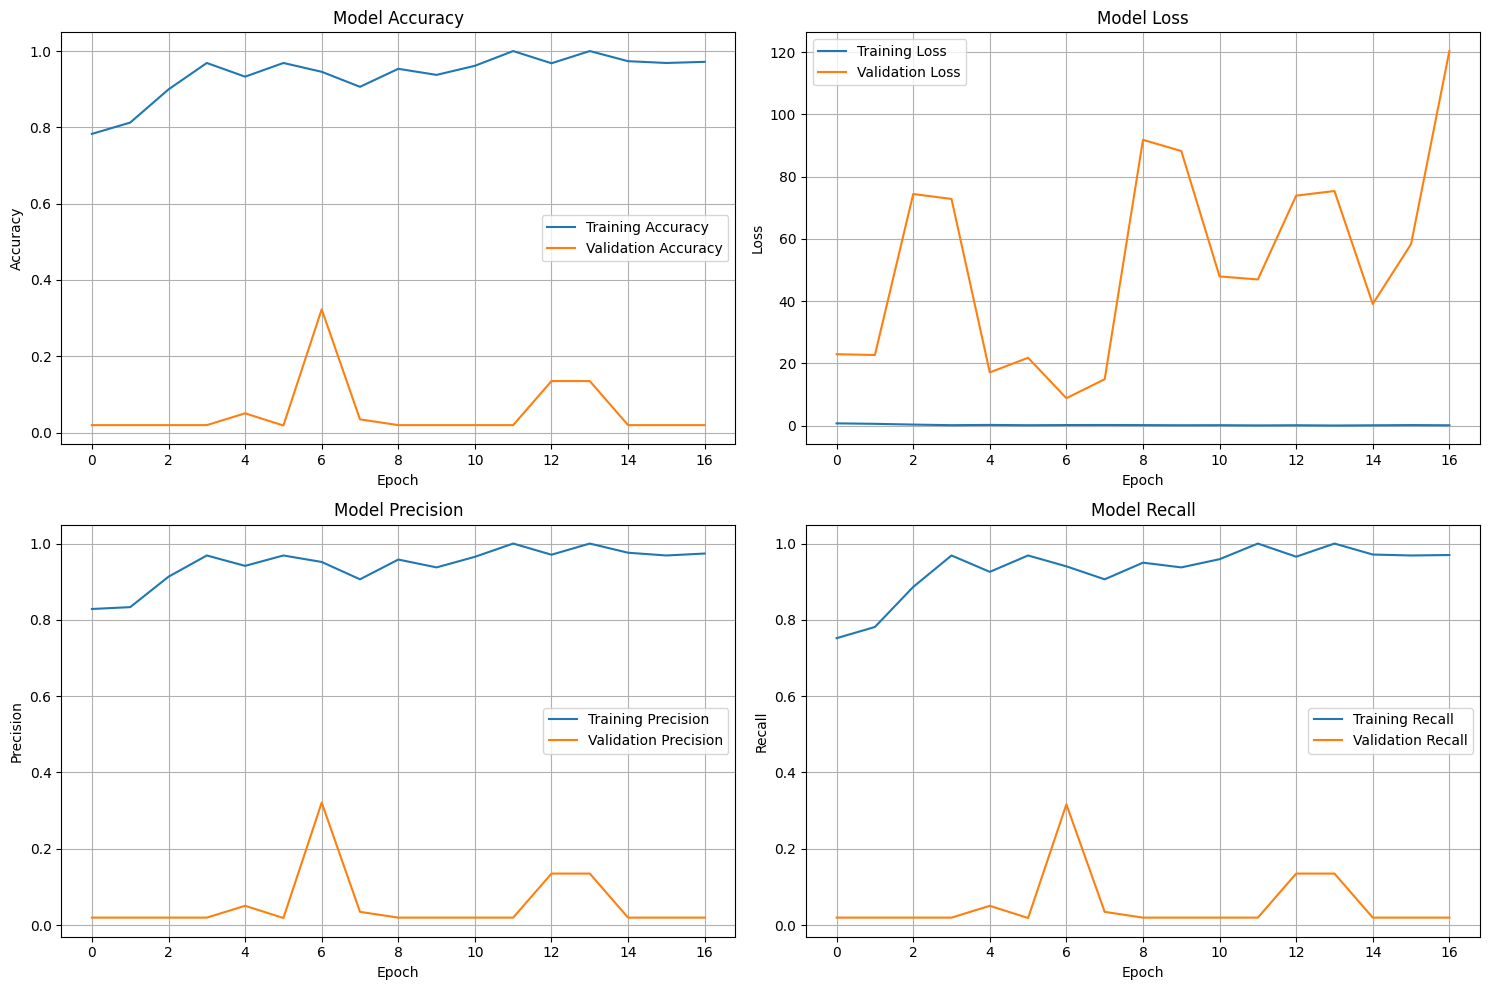

Evaluating model on test data...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


213/213 ━━━━━━━━━━━━━━━━━━━━ 2690s 13s/step
Test Accuracy: 0.4652

Classification Report:
                                    precision    recall  f1-score   support

          Left Bundle Branch Block       0.00      0.00      0.00       341
                            Normal       0.95      0.82      0.88      2179
      Premature Atrial Contraction       1.00      0.00      0.00      1503
Premature Ventricular Contractions       0.00      0.00      0.00       915
         Right Bundle Branch Block       0.55      0.71      0.62      1645
          Ventricular Fibrillation       0.08      0.92      0.14       233

                          accuracy                           0.47      6816
                         macro avg       0.43      0.41      0.27      6816
                      weighted avg       0.66      0.47      0.44      6816



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

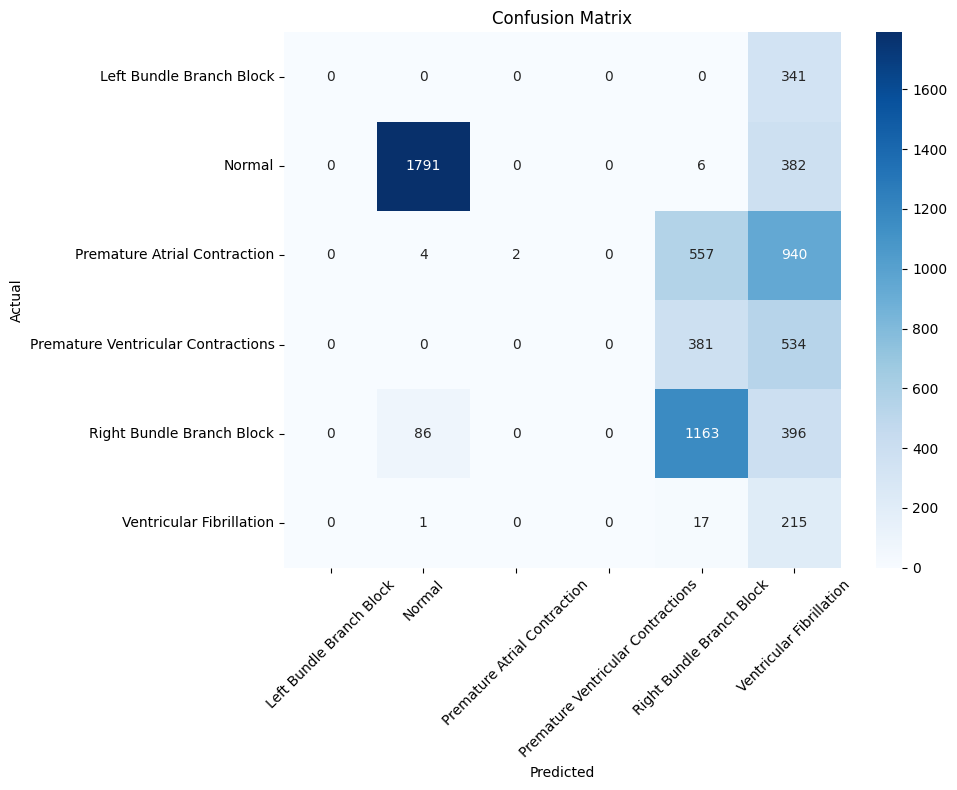

Model saved as ecg_arrhythmia_model.h5
Model artifacts saved successfully!

FINAL RESULTS
Final Test Accuracy: 0.4652
Model saved as: ecg_arrhythmia_model.h5
Additional files saved:
- class_indices.json (for Flask app)
- model_config.json (model configuration)
- training_history.png (training plots)
- confusion_matrix.png (confusion matrix)
- best_ecg_model.h5 (best model checkpoint)


In [7]:
# Run the main function
if __name__ == "__main__":
    # Mount Google Drive (uncomment if using Google Colab)
    # from google.colab import drive
    # drive.mount('/content/drive')

    main()

In [8]:
# # Additional utility functions for Flask integration
# def load_model_for_flask(model_path='ecg_arrhythmia_model.h5'):
#     """Load model for Flask application"""
#     model = tf.keras.models.load_model(model_path)

#     # Load class indices
#     with open('class_indices.json', 'r') as f:
#         class_indices = json.load(f)

#     # Load model config
#     with open('model_config.json', 'r') as f:
#         config = json.load(f)

#     return model, class_indices, config

In [9]:
# def preprocess_image_for_prediction(image_path, img_size=(224, 224)):
#     """Preprocess image for prediction in Flask app"""
#     image = cv2.imread(image_path)
#     image = cv2.resize(image, img_size)
#     image = image / 255.0
#     image = np.expand_dims(image, axis=0)
#     return image

In [10]:
# def predict_arrhythmia(model, image, class_indices):
#     """Make prediction for Flask app"""
#     prediction = model.predict(image)
#     predicted_class_idx = np.argmax(prediction)
#     confidence = np.max(prediction)

#     # Get class name
#     idx_to_class = {v: k for k, v in class_indices.items()}
#     predicted_class = idx_to_class[predicted_class_idx]

#     return predicted_class, confidence, prediction[0]